In [9]:
# ! cp /content/drive/MyDrive/DataScience/datasets/captcha-samples-wordpress.zip /content/

In [10]:
# ! unzip /content/captcha-samples-wordpress.zip -d /content/

In [11]:
import os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import cv2
import pickle

from sklearn.preprocessing import LabelEncoder
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Input , Dense , Conv2D , Flatten , MaxPooling2D
from keras.callbacks import EarlyStopping

In [12]:
def load_data(p):
    pattern = os.path.join(p , '*.png')
    files = glob(pattern)
    files = [item.replace("\\" , "/") for item in files]

    targets = []
    images = []

    for file in files:
       img_name = os.path.splitext(os.path.basename(file))[0]
       chars = list(img_name)

       if len(chars) != 4:
           continue

       targets.append(chars)

       img_array = cv2.imread(file)
       img_array_2d = cv2.cvtColor(img_array , cv2.COLOR_BGR2GRAY)
       img_array_2d = cv2.bitwise_not(img_array_2d)
       img_array_2d = img_array_2d / 255.0
       images.append(img_array_2d)

    targets = np.array(targets)
    images = np.array(images)

    return images , targets

In [ ]:
x_train  , y_train = load_data("../datasets/captcha-samples-wordpress/train/")
x_test , y_test = load_data("../datasets/captcha-samples-wordpress/test/")

In [14]:
print(f"x_train shape ==> {x_train.shape}")
print(f"x_test shape ==> {x_test.shape}")
print("----")
print(f"y_train shape ==> {y_train.shape}")
print(f"y_test shape ==> {y_test.shape}")

x_train shape ==> (9843, 24, 72)
x_test shape ==> (100, 24, 72)
----
y_train shape ==> (9843, 4)
y_test shape ==> (100, 4)


In [15]:
encoder = LabelEncoder()

encoder.fit(y_train.reshape(-1))

LabelEncoder()

In [16]:
# with open("captcha_encoder.bin" , "wb") as f:
#   pickle.dump(encoder , f)

In [17]:
def train_model(x_train , y_train_encoded , y_test_encoded , encoder):

    num_classes = len(encoder.classes_)
    
    y_train_one_hot = to_categorical(y_train_encoded , num_classes=num_classes)
    y_test_one_hot = to_categorical(y_test_encoded , num_classes=num_classes)

    model = Sequential()

    model.add(Input(shape=(x_train.shape[1] , x_train.shape[2] , 1)))
    # Feature learning
    model.add(Conv2D(4 , (3 ,3) , padding="same"))
    model.add(Conv2D(8 , (3 ,3) , padding="same"))
    model.add(Conv2D(16 , (3 ,3) , padding="same"))
    model.add(Conv2D(32 , (3 ,3) , padding="same"))
    # Flatting
    model.add(Flatten())
    # Classification
    model.add(Dense(256 , activation="relu"))
    model.add(Dense(128 , activation="relu"))
    model.add(Dense(64 , activation="relu"))
    model.add(Dense(y_train_one_hot.shape[1] , activation="softmax"))

    model.summary()

    model.compile(optimizer="adam" , loss="categorical_crossentropy" , metrics=["accuracy"])

    early_stopper = EarlyStopping(min_delta=0.0001 , patience=5 , restore_best_weights=True , verbose=False)
    res = model.fit(x_train , y_train_one_hot , epochs=30 , callbacks=[early_stopper] , validation_data=(x_test , y_test_one_hot))

    return res , model

In [18]:
assets = []
for i in range(4):
  y_train_encoded_i = encoder.transform(y_train[: , i])
  y_test_encoded_i = encoder.transform(y_test[: , i])

  result_i , model_i = train_model(x_train , y_train_encoded_i , y_test_encoded_i , encoder)
  assets.append((result_i , model_i))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 24, 72, 4)      │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 72, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 24, 72, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 55296)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    14,156,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,205,408 (54.19 MB)

 Trainable params: 14,205,408 (54.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


2025-05-31 14:50:57.532387: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 68034816 exceeds 10% of free system memory.
2025-05-31 14:50:57.754811: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 68034816 exceeds 10% of free system memory.


308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2092 - loss: 2.7702

2025-05-31 14:51:13.416765: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 56623104 exceeds 10% of free system memory.


308/308 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.2098 - loss: 2.7676 - val_accuracy: 0.7900 - val_loss: 0.5929
Epoch 2/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8322 - loss: 0.4926 - val_accuracy: 0.9000 - val_loss: 0.2698
Epoch 3/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9382 - loss: 0.1800 - val_accuracy: 0.9000 - val_loss: 0.3375
Epoch 4/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9637 - loss: 0.1051 - val_accuracy: 0.9400 - val_loss: 0.2493
Epoch 5/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9659 - loss: 0.1020 - val_accuracy: 0.9200 - val_loss: 0.1901
Epoch 6/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9764 - loss: 0.0732 - val_accuracy: 0.9700 - val_loss: 0.1671
Epoch 7/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9795 - loss: 0.0593 - val_accuracy: 0.9300 - val_loss: 0.1954
Epoch 8/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9743 - loss: 0.0764 - val_accuracy: 0.9400 -

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 24, 72, 4)      │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 24, 72, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 24, 72, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 24, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 55296)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │    14,156,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         2,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,205,408 (54.19 MB)

 Trainable params: 14,205,408 (54.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.1674 - loss: 2.9485 - val_accuracy: 0.7000 - val_loss: 0.8636
Epoch 2/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7745 - loss: 0.6431 - val_accuracy: 0.8200 - val_loss: 0.4456
Epoch 3/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9203 - loss: 0.2340 - val_accuracy: 0.9100 - val_loss: 0.2160
Epoch 4/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9574 - loss: 0.1255 - val_accuracy: 0.9700 - val_loss: 0.1052
Epoch 5/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9693 - loss: 0.0880 - val_accuracy: 0.9600 - val_loss: 0.1359
Epoch 6/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9681 - loss: 0.0988 - val_accuracy: 0.9700 - val_loss: 0.1194
Epoch 7/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9770 - loss: 0.0741 - val_accuracy: 0.9400 - val_loss: 0.2344
Epoch 8/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9776 - loss: 0.0670 - val_accurac

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 24, 72, 4)      │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 24, 72, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 24, 72, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 24, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 55296)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │    14,156,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │         2,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,205,408 (54.19 MB)

 Trainable params: 14,205,408 (54.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.1706 - loss: 2.9454 - val_accuracy: 0.6300 - val_loss: 1.1342
Epoch 2/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.7716 - loss: 0.6907 - val_accuracy: 0.7900 - val_loss: 0.5637
Epoch 3/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9129 - loss: 0.2553 - val_accuracy: 0.8500 - val_loss: 0.4371
Epoch 4/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9462 - loss: 0.1547 - val_accuracy: 0.9000 - val_loss: 0.3181
Epoch 5/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9635 - loss: 0.1119 - val_accuracy: 0.9000 - val_loss: 0.2800
Epoch 6/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9644 - loss: 0.1099 - val_accuracy: 0.8700 - val_loss: 0.3733
Epoch 7/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9691 - loss: 0.0905 - val_accuracy: 0.9500 - val_loss: 0.1249
Epoch 8/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9746 - loss: 0.0714 - val_accuracy:

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 24, 72, 4)      │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 24, 72, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 24, 72, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 24, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 55296)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │    14,156,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,205,408 (54.19 MB)

 Trainable params: 14,205,408 (54.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.2130 - loss: 2.7988 - val_accuracy: 0.7900 - val_loss: 0.6648
Epoch 2/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8482 - loss: 0.4552 - val_accuracy: 0.9000 - val_loss: 0.4012
Epoch 3/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9449 - loss: 0.1586 - val_accuracy: 0.9500 - val_loss: 0.2708
Epoch 4/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9672 - loss: 0.1013 - val_accuracy: 0.9700 - val_loss: 0.0817
Epoch 5/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9756 - loss: 0.0833 - val_accuracy: 0.9400 - val_loss: 0.2442
Epoch 6/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9786 - loss: 0.0642 - val_accuracy: 0.9200 - val_loss: 0.2449
Epoch 7/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9786 - loss: 0.0665 - val_accuracy: 0.9500 - val_loss: 0.3021
Epoch 8/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9808 - loss: 0.0615 - val_accuracy: 

In [30]:
results , models = zip(*assets)
result_one , result_two , result_three , result_four = results
model_one , model_two , model_three , model_four = models

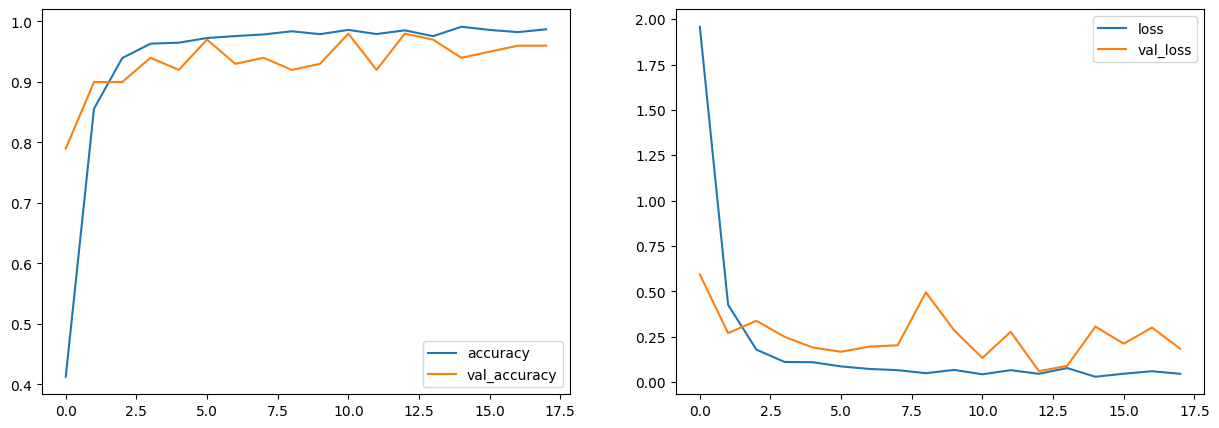

In [32]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(result_one.history["accuracy"] , label="accuracy")
plt.plot(result_one.history["val_accuracy"] , label="val_accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(result_one.history["loss"] , label="loss")
plt.plot(result_one.history["val_loss"] , label="val_loss")
plt.legend()

plt.show()

In [ ]:
# model_one.save("captcha_model.h5")
# model_two.save("captcha_model_two.h5")
# model_three.save("captcha_model_three.h5")
# model_four.save("captcha_model_four.h5")

In [33]:
def predict_model(model , img):
    img_array = cv2.imread(img)
    img_array_2d = cv2.cvtColor(img_array , cv2.COLOR_BGR2GRAY)
    img_array_2d = cv2.bitwise_not(img_array_2d)
    img_array_2d = img_array_2d / 255.0

    plt.figure(figsize=(5,5))
    plt.imshow(img_array_2d , "gray")

    result = model.predict(img_array_2d.reshape(1 , 24 , 72 , 1))
    print(encoder.inverse_transform([np.argmax(result)]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
['B']


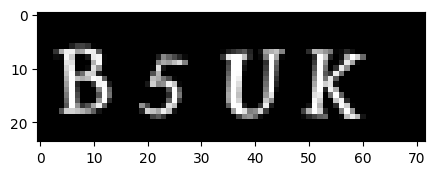

In [35]:
predict_model(model_one , "../datasets/captcha-samples-wordpress/test/B5UK.png")

In [ ]:
# ! ls

In [ ]:
# ! ls -lh captcha_model.h5

In [ ]:
# ! cp /content/captcha_model_two.h5 /content/drive/MyDrive/DataScience/saved_models